In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from scripts.analysis import data

plt.style.use("seaborn-v0_8-colorblind")
plt.rcParams["font.family"] = "monospace"
W, H = 8, 4

In [2]:
repos = data.get_fake_star_repos_all()
stars = data.get_stars_by_month_all()
repos_all = set(stars.repo)
repos_with_compaign = data.get_repo_with_compaign()
repos_alive = set(repos[repos.repo_id.notna()].repo_name)

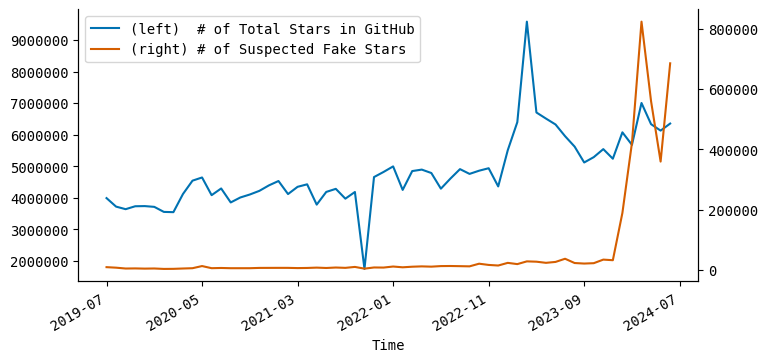

In [3]:
fig, ax = plt.subplots(figsize=(W, H))
pd.read_csv("data/all_github_stars_by_month.csv").plot(
    ax=ax, secondary_y=False, logy=False
)
stars["n_stars_fake"] = stars.n_stars_low_activity + stars.n_stars_clustered
ax2 = (
    stars[stars.month != "2024-07"]
    .groupby("month")
    .agg(
        n_stars_fake=("n_stars_fake", "sum"),
    )
    .plot(ax=ax, secondary_y=True, logy=False, color=["C2", "C1"])
)
# Ugly formatting code
ax2.ticklabel_format(style="plain", axis="y")
ax.ticklabel_format(style="plain", axis="y")
labels = ax.get_xticklabels()
labels[7].set_text("2024-07")
ax.set_xticklabels(labels)
ax.set_xlabel("Time")
ax.legend(
    labels=[
        "(left)  # of Total Stars in GitHub",
        "(right) # of Suspected Fake Stars",
    ],
    handles=[ax.lines[0], ax2.lines[0]],
)
ax.spines["top"].set_visible(False)
ax2.spines["top"].set_visible(False)
fig.autofmt_xdate()
fig.savefig("plots/num_fake_stars.png", bbox_inches="tight", dpi=300)

Counter({False: 1001674, True: 221608})
Counter({False: 362117, True: 77007})
Counter({False: 649768, True: 146811})


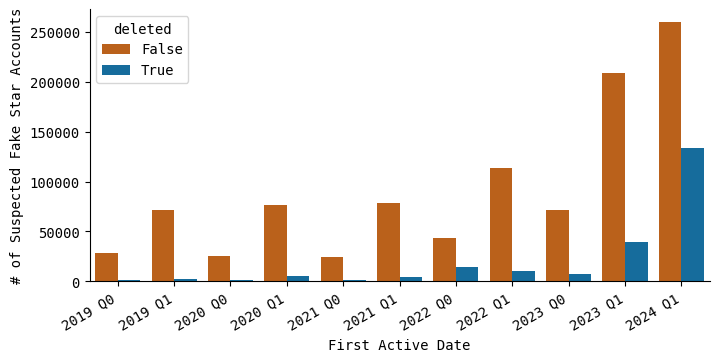

In [4]:
users = data.get_fake_star_users()

date_to_quarter = lambda x: x[:4] + " Q" + str(int(x[4:6]) // 3 + 1)
users.first_active = users.first_active.map(date_to_quarter)
users.last_active = users.last_active.map(date_to_quarter)

print(Counter(users.deleted))
print(Counter(users[users.clustered].deleted))
print(Counter(users[users.low_activity].deleted))

user_to_deletion = (
    users.groupby(["first_active", "deleted"]).size().reset_index(name="n_users")
)

fig, ax = plt.subplots(figsize=(W, H))
sns.barplot(
    data=user_to_deletion,
    x="first_active",
    y="n_users",
    hue="deleted",
    ax=ax,
    palette=["C2", "C0"],
)
ax.set_xlabel("First Active Date")
ax.set_ylabel("# of Suspected Fake Star Accounts")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.autofmt_xdate()
fig.savefig("plots/users.png", bbox_inches="tight", dpi=300)

[(1, 100.0), (2, 7.861181949218317), (3, 1.2085597072846213), (4, 0.6763499279299258), (5, 0.45459585319880247), (6, 0.28828029715046016), (7, 0.18849096352145472), (8, 0.1330524448386739), (9, 0.1108770373655616), (10, 0.09978933362900543), (11, 0.0776139261558931)]


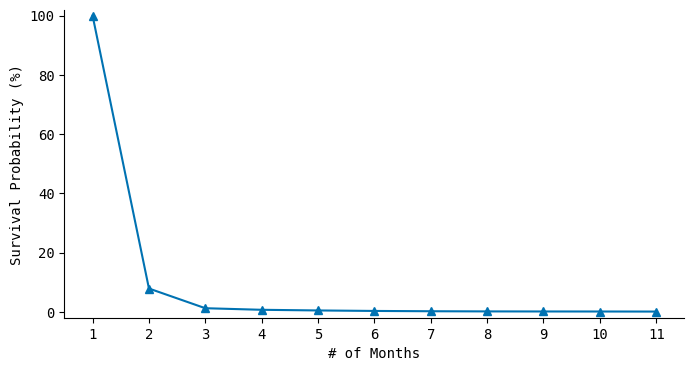

In [5]:
repo_to_months = (
    stars.groupby("repo")
    .agg(
        n_months=("month", "count"),
    )
    .reset_index()
)
repo_to_months = repo_to_months[repo_to_months.repo.isin(repos_with_compaign)]

fig, ax = plt.subplots(figsize=(W, H))
data = []
for i in range(1, 12):
    data.append(
        (
            i,
            (
                repo_to_months[
                    ~repo_to_months.repo.isin(repos_alive)
                    & (repo_to_months.n_months >= i)
                ].shape[0]
                # repo_to_months[repo_to_months.repo.isin(repos_alive)].shape[0]
            )
            / repo_to_months[~repo_to_months.repo.isin(repos_alive)].shape[0]
            * 100,
        )
    )
print(data)
ax.plot(*zip(*data), marker="^")
ax.set_ylabel("Survival Probability (%)")
ax.set_xlabel("# of Months")
ax.set_ylim(-2, 102)
ax.set_xticks(range(1, 12))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.savefig("plots/survival.png", bbox_inches="tight", dpi=300)

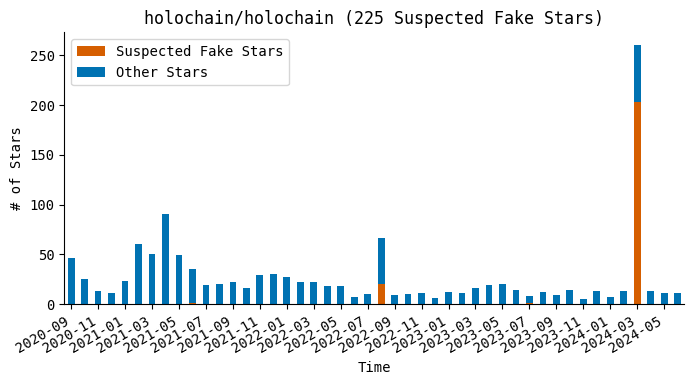

In [6]:
fig, ax = plt.subplots(figsize=(W, H))
repos[repos.repo_name == "holochain/holochain"]
stars[stars.repo == "holochain/holochain"][
    ["month", "n_stars_fake", "n_stars_other"]
].plot(
    kind="bar",
    stacked=True,
    x="month",
    color=["C2", "C0"],
    ax=ax,
    title=f"holochain/holochain ({225} Suspected Fake Stars)",
)
ax.set_xticks(ax.get_xticks()[::2])
ax.set_ylabel("# of Stars")
ax.set_xlabel("Time")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(["Suspected Fake Stars", "Other Stars"])
fig.autofmt_xdate()
fig.savefig("plots/holochain.png", bbox_inches="tight", dpi=300)

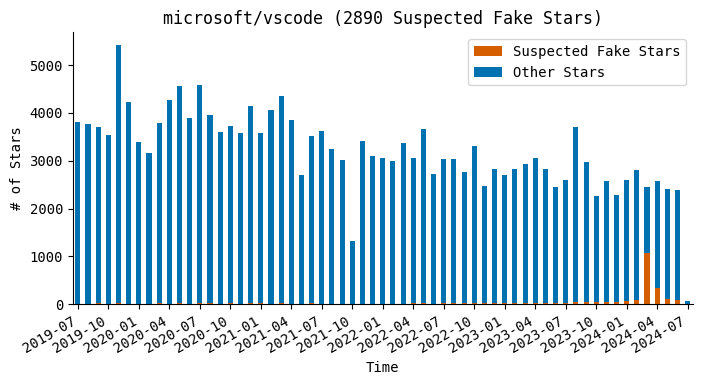

In [7]:
fig, ax = plt.subplots(figsize=(W, H))
repo_name = "microsoft/vscode"
n_fakes = (
    repos[repos.repo_name == repo_name].n_stars_clustered.values[0]
    + repos[repos.repo_name == repo_name].n_stars_low_activity.values[0]
)
stars[stars.repo == repo_name][["month", "n_stars_fake", "n_stars_other"]].plot(
    kind="bar",
    stacked=True,
    x="month",
    color=["C2", "C0"],
    ax=ax,
    title=f"{repo_name} ({int(n_fakes)} Suspected Fake Stars)",
)
ax.set_ylabel("# of Stars")
ax.set_xlabel("Time")
ax.set_xticks(ax.get_xticks()[::3])
ax.legend(["Suspected Fake Stars", "Other Stars"])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.autofmt_xdate()
fig.savefig("plots/vscode.png", bbox_inches="tight", dpi=300)

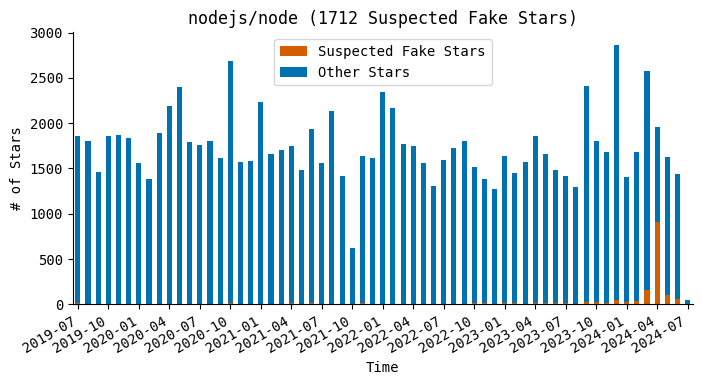

In [8]:
fig, ax = plt.subplots(figsize=(W, H))
repo_name = "nodejs/node"
n_fakes = (
    repos[repos.repo_name == repo_name].n_stars_clustered.values[0]
    + repos[repos.repo_name == repo_name].n_stars_low_activity.values[0]
)
stars[stars.repo == repo_name][["month", "n_stars_fake", "n_stars_other"]].plot(
    kind="bar",
    stacked=True,
    x="month",
    color=["C2", "C0"],
    ax=ax,
    title=f"{repo_name} ({int(n_fakes)} Suspected Fake Stars)",
)
ax.set_xticks(ax.get_xticks()[::3])
ax.set_ylabel("# of Stars")
ax.set_xlabel("Time")
ax.legend(["Suspected Fake Stars", "Other Stars"])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.autofmt_xdate()
fig.savefig("plots/node.png", bbox_inches="tight", dpi=300)

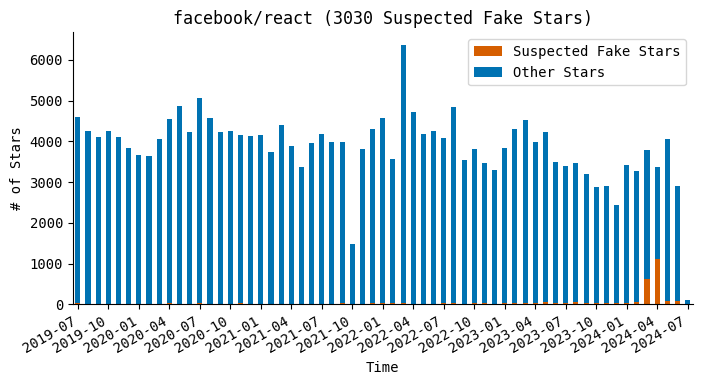

In [9]:
fig, ax = plt.subplots(figsize=(W, H))
repo_name = "facebook/react"
n_fakes = (
    repos[repos.repo_name == repo_name].n_stars_clustered.values[0]
    + repos[repos.repo_name == repo_name].n_stars_low_activity.values[0]
)
stars[stars.repo == repo_name][["month", "n_stars_fake", "n_stars_other"]].plot(
    kind="bar",
    stacked=True,
    x="month",
    color=["C2", "C0"],
    ax=ax,
    title=f"{repo_name} ({int(n_fakes)} Suspected Fake Stars)",
)
ax.set_xticks(ax.get_xticks()[::3])
ax.set_ylabel("# of Stars")
ax.set_xlabel("Time")
ax.legend(["Suspected Fake Stars", "Other Stars"])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.autofmt_xdate()
fig.savefig("plots/react.png", bbox_inches="tight", dpi=300)

In [10]:
filter = repos.repo_name.map(
    lambda x: "awesome" in x.lower()
    or "beginner" in x.lower()
    or "interview" in x.lower()
    or "demo" in x.lower()
    or "example" in x.lower()
    or "template" in x.lower()
    or "interview" in x.lower()
) & repos.repo_name.isin(repos_with_compaign)
for i, row in enumerate(repos[filter].itertuples()):
    print(
        row.repo_name,
        int(row.n_stars),
        f"stars ({int(row.n_stars_clustered+row.n_stars_low_activity)} fakes)",
    )

olddemoniron/mineralz-AutoClicker 196 stars (196 fakes)
olddemonsocuteboy/momoai-AutoClicker 207 stars (207 fakes)
demonxaocazekeplays/solid-adventure 69 stars (69 fakes)
danidan4/voice-changer-client-demo 161 stars (161 fakes)
Recognito-Vision/Face-SDK-iOS-Demo 93 stars (93 fakes)
dsnbey/MVVM-Layered-Architecture-Example 237 stars (236 fakes)
1321928757/Concurrent-MulThread-Demo 81 stars (80 fakes)
dnbmagic/farcaster-examples 68 stars (67 fakes)
dnbmagic/awesome-frames 64 stars (63 fakes)
solidglue/tensorflow2_examples_jupyter 61 stars (60 fakes)
andeug/code-examples 490 stars (478 fakes)
Recognito-Vision/Face-SDK-Android-Demo 98 stars (95 fakes)
StrawHat1Luffy/farcaster-examples 69 stars (64 fakes)
solidglue/sklearn_examples_jupyter 69 stars (61 fakes)
scayle/demo-add-on-vite 70 stars (61 fakes)
Foblex/f-flow-example 77 stars (67 fakes)
Recognito-Vision/Face-SDK-Linux-Demos 109 stars (89 fakes)
52jing/wang-template-backend 126 stars (100 fakes)
ai-boost/awesome-prompts 3892 stars (30